# Modelling with NN

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [96]:
df = pd.read_csv('data_with_new_features.csv', sep=';')
df = df.drop('street', axis=1)

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925 entries, 0 to 924
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   number of rooms       925 non-null    int64  
 1   area of apartment     925 non-null    float64
 2   number of floors      925 non-null    int64  
 3   apartment floor       925 non-null    int64  
 4   price                 925 non-null    float64
 5   repair                925 non-null    object 
 6   bathroom              925 non-null    object 
 7   terrace               925 non-null    object 
 8   year of construction  925 non-null    int64  
 9   elevator              925 non-null    int64  
 10  garbage chute         925 non-null    int64  
 11  type of house         925 non-null    object 
 12  district              925 non-null    object 
 13  concierge             925 non-null    int64  
 14  distance              925 non-null    float64
 15  price for metre       9

## Подготовка категориальных признаков

### Разбиение на данные и целевую метку

In [98]:
not_categorial_features = []
for column in df.columns:
    if df[column].dtype != 'object':
        not_categorial_features.append(column)

data = df[not_categorial_features].copy().drop('price', axis=1)
target = df[['price']].copy()

### One-Hot-кодирование для категориальных признаков

In [99]:
from sklearn.preprocessing import OneHotEncoder

def get_one_hot_df(df, column):
    encoder = OneHotEncoder()
    new_df = pd.DataFrame(encoder.fit_transform(df[[column]]).toarray())
    new_df.columns = [column + '_' + feature[3:] for feature in encoder.get_feature_names()]
    return new_df

for column in df.columns:
    if df[column].dtype == 'object':
        one_hot_df = get_one_hot_df(df, column)
        data = pd.merge(data, one_hot_df, left_index=True, right_index=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925 entries, 0 to 924
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   number of rooms                 925 non-null    int64  
 1   area of apartment               925 non-null    float64
 2   number of floors                925 non-null    int64  
 3   apartment floor                 925 non-null    int64  
 4   year of construction            925 non-null    int64  
 5   elevator                        925 non-null    int64  
 6   garbage chute                   925 non-null    int64  
 7   concierge                       925 non-null    int64  
 8   distance                        925 non-null    float64
 9   price for metre                 925 non-null    float64
 10  district population             925 non-null    int64  
 11  green rate                      925 non-null    int64  
 12  repair rate                     925 

## Деление на тестовую и тренировочную выборки

In [100]:
X = data.values
y = target.values

X.shape, y.shape

((925, 37), (925, 1))

In [101]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.8, 
                                                    random_state=42)

In [102]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, 
                                                    train_size=0.8, 
                                                    random_state=42)

In [103]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
X_valid = X_valid.astype(np.float32)

y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)
y_valid = y_valid.astype(np.float32)

## Стандартизация количественных признаков

In [104]:
not_categorial_features.remove('price')

In [105]:
from sklearn.preprocessing import StandardScaler

scalers = []
for index in range(len(not_categorial_features)):
    scaler = StandardScaler()
    X_train[:, index] = scaler.fit_transform(X_train[:, index].reshape(-1, 1)).reshape(-1)
    scalers.append(scaler)

In [106]:
for index in range(len(not_categorial_features)):
    scaler = scalers[index]
    X_valid[:, index] = scaler.transform(X_valid[:, index].reshape(-1, 1)).reshape(-1)

In [107]:
for index in range(len(not_categorial_features)):
    scaler = scalers[index]
    X_test[:, index] = scaler.transform(X_test[:, index].reshape(-1, 1)).reshape(-1)

In [108]:
y_train /= 1_000_000
y_valid /= 1_000_000
y_test /= 1_000_000

# Нейронная сеть

### Формирование наборов для обучения и оценки

In [109]:
from torch import from_numpy
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [110]:
inputs = torch.from_numpy(X_train)
targets = torch.from_numpy(y_train)
train_ds = TensorDataset(inputs, targets)

batch_size = 10
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [111]:
inputs = torch.from_numpy(X_valid)
targets = torch.from_numpy(y_valid)
valid_ds = TensorDataset(inputs, targets)

batch_size = 10
valid_dl = DataLoader(valid_ds, batch_size, shuffle=True)

In [127]:
test_data = torch.from_numpy(X_valid)
test_target = torch.from_numpy(y_valid)

### Базовый класс и функции

In [113]:
import torch.nn as nn
import torch.nn.functional as F

In [114]:
class BaseRegressor(nn.Module):
    
    def training_step(self, batch):
        data, labels = batch
        out = self(data)
        loss = F.mse_loss(out, labels)
        return loss

    def validation_step(self, batch):
        data, labels = batch
        out = self(data)
        loss = F.mse_loss(out, labels)
        return {'RMSE': np.sqrt(loss.detach())}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['RMSE'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'RMSE': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], RMSE: {:.4f}".format(
            epoch, result['RMSE']))

In [120]:
def fit(n_epochs, lr, model, train_loader, val_loader, every_n_epoch_print, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = []

    for epoch in range(n_epochs):
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        if epoch % every_n_epoch_print == 0:
            model.epoch_end(epoch, result)
        history.append(result)

    return history

In [121]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

### Простой перспетрон

In [129]:
class SimpleRegressor(BaseRegressor):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(37, 1, bias=False))
    
    def forward(self, xb):
        return self.network(xb)

In [136]:
n_epoch = 6001
model = SimpleRegressor()
loss_fn = F.mse_loss
lr=1e-5


history = fit(n_epoch, lr, model, train_dl, valid_dl, 600)

Epoch [0], RMSE: 3.8728
Epoch [600], RMSE: 1.2635
Epoch [1200], RMSE: 0.7114
Epoch [1800], RMSE: 0.6103
Epoch [2400], RMSE: 0.5665
Epoch [3000], RMSE: 0.5451
Epoch [3600], RMSE: 0.5094
Epoch [4200], RMSE: 0.5101
Epoch [4800], RMSE: 0.4998
Epoch [5400], RMSE: 0.4910
Epoch [6000], RMSE: 0.4791


In [137]:
model.validation_step((test_data, test_target))

{'RMSE': tensor(0.5072)}

## Многослойный персептрон 1

In [143]:
class MultiLayerRegressor1(BaseRegressor):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(37, 10, bias=False),
            nn.Linear(10, 1, bias=False))
    
    def forward(self, xb):
        return self.network(xb)

In [144]:
n_epoch = 6001
multi1 = MultiLayerRegressor1()
loss_fn = F.mse_loss
lr=1e-5


history_multi1 = fit(n_epoch, lr, multi1, train_dl, valid_dl, 600)

Epoch [0], RMSE: 3.6034
Epoch [600], RMSE: 0.7483
Epoch [1200], RMSE: 0.5421
Epoch [1800], RMSE: 0.4877
Epoch [2400], RMSE: 0.4734
Epoch [3000], RMSE: 0.4738
Epoch [3600], RMSE: 0.4682
Epoch [4200], RMSE: 0.4650
Epoch [4800], RMSE: 0.4662
Epoch [5400], RMSE: 0.4616
Epoch [6000], RMSE: 0.4688


In [145]:
multi1.validation_step((test_data, test_target))

{'RMSE': tensor(0.4878)}

## Многослойный персептрон 2

In [146]:
class MultiLayerRegressor2(BaseRegressor):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(37, 100, bias=False),
            nn.Linear(100, 1, bias=False))
    
    def forward(self, xb):
        return self.network(xb)

In [147]:
n_epoch = 6001
multi2 = MultiLayerRegressor2()
loss_fn = F.mse_loss
lr=1e-5


history_multi2 = fit(n_epoch, lr, multi2, train_dl, valid_dl, 600)

Epoch [0], RMSE: 3.6326
Epoch [600], RMSE: 0.5749
Epoch [1200], RMSE: 0.4982
Epoch [1800], RMSE: 0.4669
Epoch [2400], RMSE: 0.4680
Epoch [3000], RMSE: 0.4629
Epoch [3600], RMSE: 0.4693
Epoch [4200], RMSE: 0.4512
Epoch [4800], RMSE: 0.4521
Epoch [5400], RMSE: 0.4564
Epoch [6000], RMSE: 0.4567


In [148]:
multi2.validation_step((test_data, test_target))

{'RMSE': tensor(0.4857)}

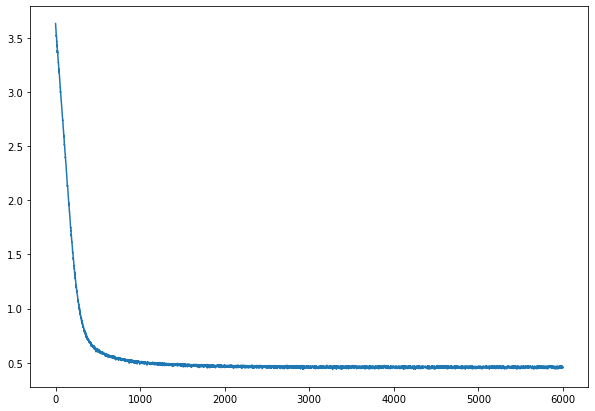

In [160]:
x = [item['RMSE'] for item in history_multi2]
plt.figure(figsize=(10, 7))
plt.plot(x)

## Многослойный персептрон 3

In [161]:
class MultiLayerRegressor3(BaseRegressor):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(37, 100, bias=False),
            nn.Linear(100, 20, bias=False),
            nn.Linear(20, 1, bias=False))
    
    def forward(self, xb):
        return self.network(xb)

In [162]:
n_epoch = 6001
multi3 = MultiLayerRegressor3()
loss_fn = F.mse_loss
lr=1e-5


history_multi3 = fit(n_epoch, lr, multi3, train_dl, valid_dl, 600)

Epoch [0], RMSE: 3.6276
Epoch [600], RMSE: 0.6191
Epoch [1200], RMSE: 0.4974
Epoch [1800], RMSE: 0.4886
Epoch [2400], RMSE: 0.4604
Epoch [3000], RMSE: 0.4575
Epoch [3600], RMSE: 0.4560
Epoch [4200], RMSE: 0.4637
Epoch [4800], RMSE: 0.4511
Epoch [5400], RMSE: 0.4682
Epoch [6000], RMSE: 0.4529


In [163]:
multi3.validation_step((test_data, test_target))

{'RMSE': tensor(0.4894)}

## Многослойный персептрон 4 c активационными функциями ReLU

In [164]:
class MultiLayerRegressor4(BaseRegressor):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(37, 100, bias=False),
            nn.ReLU(),
            nn.Linear(100, 20, bias=False),
            nn.ReLU(),
            nn.Linear(20, 1, bias=False))
    
    def forward(self, xb):
        return self.network(xb)

In [165]:
n_epoch = 6001
multi4 = MultiLayerRegressor4()
loss_fn = F.mse_loss
lr=1e-5


history_multi4 = fit(n_epoch, lr, multi4, train_dl, valid_dl, 600)

Epoch [0], RMSE: 3.6367
Epoch [600], RMSE: 0.6938
Epoch [1200], RMSE: 0.5511
Epoch [1800], RMSE: 0.5320
Epoch [2400], RMSE: 0.5141
Epoch [3000], RMSE: 0.5134
Epoch [3600], RMSE: 0.5019
Epoch [4200], RMSE: 0.4955
Epoch [4800], RMSE: 0.4846
Epoch [5400], RMSE: 0.4843
Epoch [6000], RMSE: 0.4818


In [166]:
multi4.validation_step((test_data, test_target))

{'RMSE': tensor(0.5140)}

## Многослойный персептрон 5 c одинаковыми по количествую нейронов слоями и активацией ReLU

In [167]:
class MultiLayerRegressor5(BaseRegressor):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(37, 100, bias=False),
            nn.ReLU(),
            nn.Linear(100, 100, bias=False),
            nn.ReLU(),
            nn.Linear(100, 1, bias=False))
    
    def forward(self, xb):
        return self.network(xb)

In [168]:
n_epoch = 6001
multi5 = MultiLayerRegressor5()
loss_fn = F.mse_loss
lr=1e-5


history_multi5 = fit(n_epoch, lr, multi5, train_dl, valid_dl, 600)

Epoch [0], RMSE: 3.6448
Epoch [600], RMSE: 0.6866
Epoch [1200], RMSE: 0.5933
Epoch [1800], RMSE: 0.5666
Epoch [2400], RMSE: 0.5577
Epoch [3000], RMSE: 0.5481
Epoch [3600], RMSE: 0.5382
Epoch [4200], RMSE: 0.5259
Epoch [4800], RMSE: 0.5142
Epoch [5400], RMSE: 0.5214
Epoch [6000], RMSE: 0.5053


In [169]:
multi5.validation_step((test_data, test_target))

{'RMSE': tensor(0.5411)}

## Многослойный персептрон 6 c одинаковыми по количествую нейронов слоями и активацией ReLU

In [172]:
class MultiLayerRegressor6(BaseRegressor):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(37, 50, bias=False),
            nn.Linear(50, 50, bias=False),
            nn.Linear(50, 1, bias=False))
    
    def forward(self, xb):
        return self.network(xb)

In [173]:
n_epoch = 6001
multi6 = MultiLayerRegressor6()
loss_fn = F.mse_loss
lr=1e-5


history_multi6 = fit(n_epoch, lr, multi6, train_dl, valid_dl, 600)

Epoch [0], RMSE: 3.6208
Epoch [600], RMSE: 0.6129
Epoch [1200], RMSE: 0.4918
Epoch [1800], RMSE: 0.4691
Epoch [2400], RMSE: 0.4621
Epoch [3000], RMSE: 0.4615
Epoch [3600], RMSE: 0.4489
Epoch [4200], RMSE: 0.4513
Epoch [4800], RMSE: 0.4587
Epoch [5400], RMSE: 0.4636
Epoch [6000], RMSE: 0.4600


In [174]:
multi6.validation_step((test_data, test_target))

{'RMSE': tensor(0.4877)}

## Многослойный персептрон 7 с оптимизатором Adam

In [189]:
class MultiLayerRegressor7(BaseRegressor):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(37, 100, bias=False),
            nn.Linear(100, 1, bias=False))
    
    def forward(self, xb):
        return self.network(xb)

In [190]:
n_epoch = 6001
multi7 = MultiLayerRegressor7()
loss_fn = F.mse_loss
lr=5e-6


history_multi7 = fit(n_epoch, lr, multi7, train_dl, valid_dl, 600, opt_func=torch.optim.Adam)

Epoch [0], RMSE: 3.5781
Epoch [600], RMSE: 0.4678
Epoch [1200], RMSE: 0.4716
Epoch [1800], RMSE: 0.4588
Epoch [2400], RMSE: 0.4552
Epoch [3000], RMSE: 0.4537
Epoch [3600], RMSE: 0.4596
Epoch [4200], RMSE: 0.4613
Epoch [4800], RMSE: 0.4636
Epoch [5400], RMSE: 0.4688
Epoch [6000], RMSE: 0.4639


In [191]:
multi7.validation_step((test_data, test_target))

{'RMSE': tensor(0.4909)}

## Многослойный персептрон 7 с оптимизатором Adam и остановкой

In [201]:
def fit_with_stop(n_epochs, lr, model, train_loader, val_loader, every_n_epoch_print, stop_value, opt_func=torch.optim.SGD):
    swap_optim = True
    
    optimizer = opt_func(model.parameters(), lr)
    history = []

    for epoch in range(n_epochs):
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
            
        if epoch % every_n_epoch_print == 0:
            model.epoch_end(epoch, result)
        history.append(result)
        
        if result['RMSE'] < torch.tensor(0.46) and swap_optim:
            optimizer = torch.optim.SGD(model.parameters(), lr)
            print("Adam->SGD")
            swap_optim = False
        
        if result['RMSE'] < stop_value:
            print("Stop")
            return history
    return history

In [199]:
n_epoch = 6001
multi7 = MultiLayerRegressor7()
loss_fn = F.mse_loss
lr=5e-6


history_multi7 = fit_with_stop(n_epoch, lr, multi7, train_dl, valid_dl, 600, torch.tensor(0.44), opt_func=torch.optim.Adam)

Epoch [0], RMSE: 3.4904
Adam->SGD
Epoch [600], RMSE: 0.4776
Epoch [1200], RMSE: 0.4731
Epoch [1800], RMSE: 0.4703
Epoch [2400], RMSE: 0.4531
Epoch [3000], RMSE: 0.4725


In [200]:
multi7.validation_step((test_data, test_target))

{'RMSE': tensor(0.4883)}

## Визуализация

In [217]:
predicts = multi7(test_data).detach().numpy() 
reals = test_target.detach().numpy() 

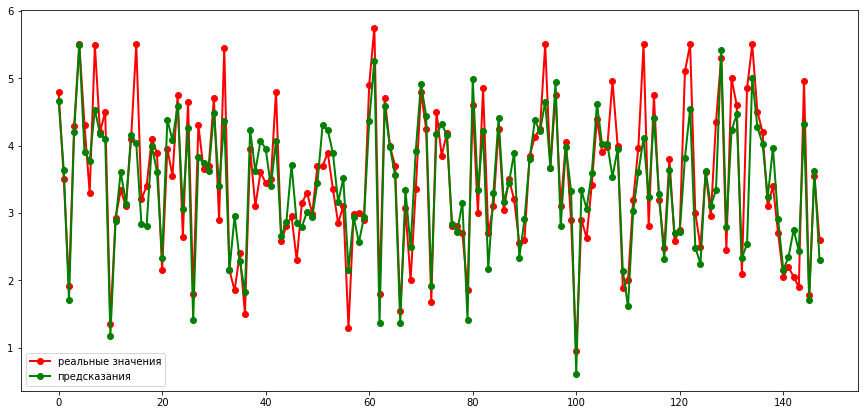

In [211]:
plt.figure(figsize=(15, 7))
plt.plot(reals, '-ro', linewidth=2, label='реальные значения')
plt.plot(predicts, '-go', linewidth=2, label='предсказания')
plt.legend()

Text(0, 0.5, 'Предсказанная цена')

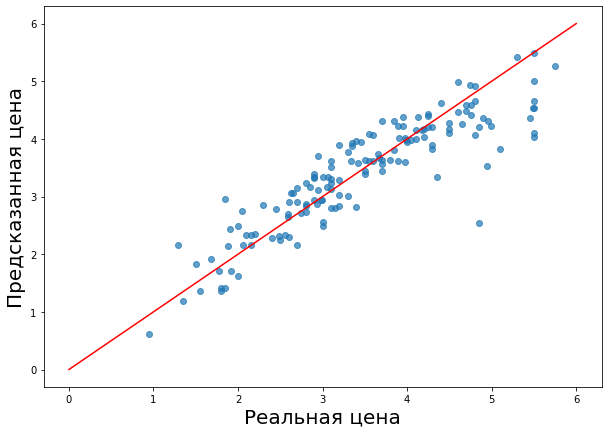

In [213]:
plt.figure(figsize=(10, 7))
plt.plot(np.array(range(7)), np.array(range(7)), c='r')
plt.scatter(reals, predicts, alpha=0.7)
plt.xlabel("Реальная цена", size=20)
plt.ylabel("Предсказанная цена", size=20)

## RMSE для квартир до 4.5 млн

In [261]:
low_predicts = []
low_reals = []
for i in range(len(predicts)):
    if reals[i] < 4.5:
        low_predicts.append(predicts[i])
        low_reals.append(reals[i])

low_predicts = np.array(low_predicts)
low_reals = np.array(low_reals)

In [262]:
from sklearn.metrics import mean_squared_error

RMSE = np.sqrt(mean_squared_error(low_predicts, low_reals))
print("RMSE: " + str(RMSE))

RMSE: 0.35612458


## RMSE для квартир от 4.5 млн

In [267]:
high_predicts = []
high_reals = []
for i in range(len(predicts)):
    if reals[i] > 4.5:
        high_predicts.append(predicts[i])
        high_reals.append(reals[i])

high_predicts = np.array(high_predicts)
high_reals = np.array(high_reals)

In [268]:
RMSE = np.sqrt(mean_squared_error(high_predicts, high_reals))
print("RMSE: " + str(RMSE))

RMSE: 0.84769624


# Итоги

Удалось дойти до средней ошибки в размере 480 тысяч рублей с помощью нейросетевого подхода. Данный результат уступает деревьям на сотню тысяч.

Также было замечено, что на квартирах стоимостью меньше 4.5 млн рублей модель показывает ошибку в пределах 350 тысяч рублей, а на квартирах дороже ошибка достигает 850 тысяч рублей. В качестве предложения можно натренировать классификатор, который обозначает квартиру как дороже 4.5 млн рублей или дешевле. И полученную метку использовать в качестве нового признака для обучения. Или можно использовать две нейросети - для квартир дешевле 4.5 млн рублей и для квартир дороже